In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Середні та STD для ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

num_classes = len(full_dataset.classes)
print(f"Кількість класів: {num_classes}")

class_names = full_dataset.classes

Кількість класів: 67


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. CPU is used.")


GPU: NVIDIA GeForce RTX 4070


In [4]:
model_nfnet = timm.create_model('dm_nfnet_f0', pretrained=True)

in_features = model_nfnet.get_classifier().in_features
model_nfnet.fc = nn.Linear(in_features, num_classes)

model_nfnet.to(device)

criterion_nfnet = nn.CrossEntropyLoss()

optimizer_nfnet = optim.AdamW(model_nfnet.parameters(), lr=1e-4, weight_decay=1e-4)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, num_epochs=10, model_name='model'):
    best_val_acc = 0.0
    total_training_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Валідація
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # Збереження найкращої моделі
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Найкраща точність валідації для {model_name}: {best_val_acc:.4f}")
    print(f"Загальний час навчання для {model_name}: {total_training_time:.2f}s")
    return total_training_time

# Функція для оцінки моделі
def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    recall = recall_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    f1 = f1_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nМетрики тестування для {model_name}:")
    print(f"Точність (Accuracy): {acc:.4f}")
    print(f"Точність (Precision): {precision:.4f}")
    print(f"Повнота (Recall): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Середній час інференсу: {avg_inference_time:.6f} s")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm

# Функція для підрахунку параметрів моделі
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    return total_params, trainable_params

In [6]:
print("\n=== Training model NFNet-F ===")
training_time_nfnet = train_model(
    model=model_nfnet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_nfnet,
    optimizer=optimizer_nfnet,
    device=device,
    num_epochs=10,
    model_name='model_dm_nfnet_f0'
)


=== Training model NFNet-F ===
Epoch 1/10 | Train Loss: 1.3112 | Train Acc: 0.6729 | Val Loss: 0.7922 | Val Acc: 0.7661 | Time: 112.05s
Epoch 2/10 | Train Loss: 0.3171 | Train Acc: 0.8988 | Val Loss: 0.7183 | Val Acc: 0.7900 | Time: 110.91s
Epoch 3/10 | Train Loss: 0.1248 | Train Acc: 0.9599 | Val Loss: 0.7464 | Val Acc: 0.8050 | Time: 108.95s
Epoch 4/10 | Train Loss: 0.0818 | Train Acc: 0.9741 | Val Loss: 0.7976 | Val Acc: 0.7939 | Time: 109.31s
Epoch 5/10 | Train Loss: 0.0616 | Train Acc: 0.9827 | Val Loss: 0.8945 | Val Acc: 0.7887 | Time: 109.59s
Epoch 6/10 | Train Loss: 0.0856 | Train Acc: 0.9750 | Val Loss: 0.7881 | Val Acc: 0.8143 | Time: 109.16s
Epoch 7/10 | Train Loss: 0.0645 | Train Acc: 0.9801 | Val Loss: 0.9456 | Val Acc: 0.7977 | Time: 108.89s
Epoch 8/10 | Train Loss: 0.0517 | Train Acc: 0.9845 | Val Loss: 0.8690 | Val Acc: 0.8011 | Time: 112.09s
Epoch 9/10 | Train Loss: 0.0434 | Train Acc: 0.9871 | Val Loss: 0.9083 | Val Acc: 0.7968 | Time: 111.43s
Epoch 10/10 | Train Los


=== Оцінка Evaluating the model ===

Метрики тестування для dm_nfnet_f0:
Точність (Accuracy): 0.8067
Точність (Precision): 0.8247
Повнота (Recall): 0.8067
F1-Score: 0.8062
Середній час інференсу: 0.010681 s


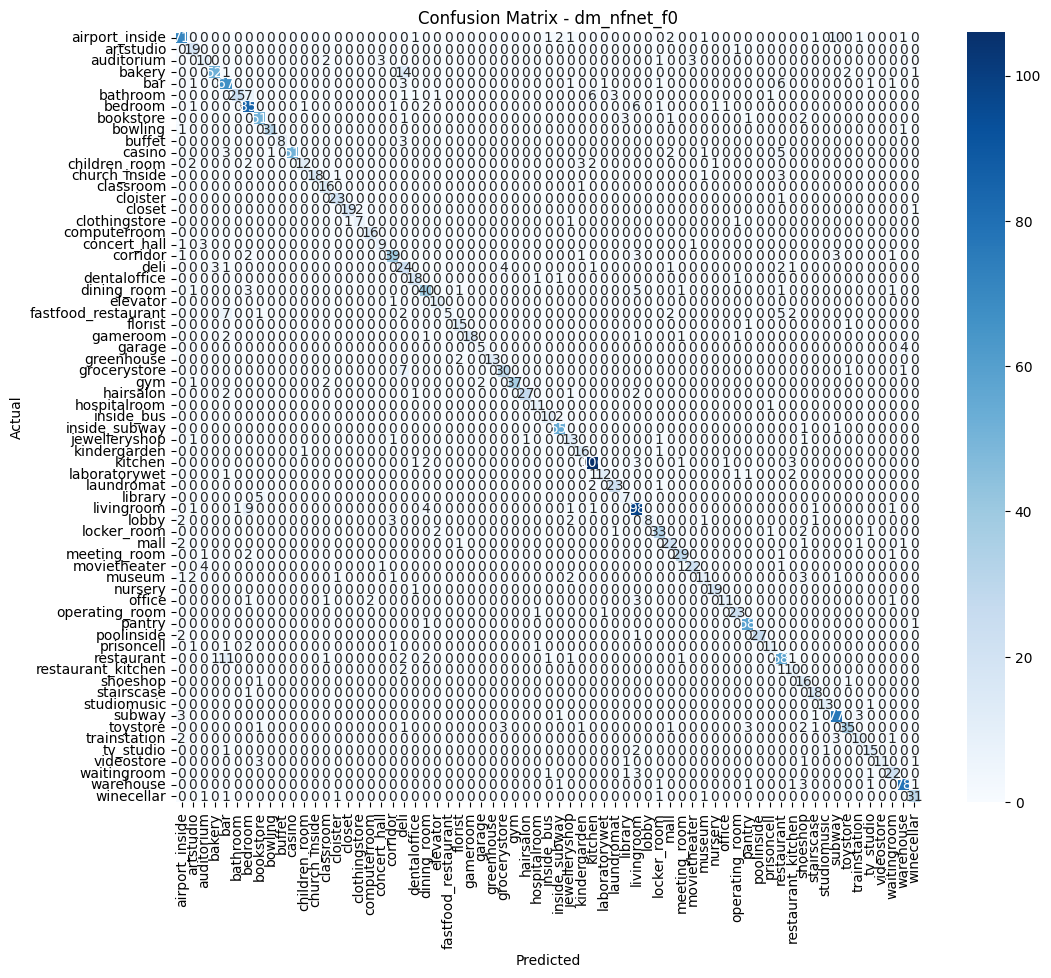

In [7]:
print("\n=== Evaluating the model ===")
model_nfnet.load_state_dict(torch.load('best_model_dm_nfnet_f0.pth'))
model_nfnet.to(device)

acc_nfnet, precision_nfnet, recall_nfnet, f1_nfnet, inference_time_nfnet, cm_nfnet = evaluate_model(
    model=model_nfnet,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='dm_nfnet_f0'
)

In [8]:
total_params_nfnet, trainable_params_nfnet = count_parameters(model_nfnet)
print(f"\ndm_nfnet_f0 - Total parameters: {total_params_nfnet}, Trainable parameters: {trainable_params_nfnet}")



dm_nfnet_f0 - Total parameters: 71695175, Trainable parameters: 71695175


In [9]:
data = {
    'Model': ['dm_nfnet_f0'],
    'Accuracy': [acc_nfnet],
    'Precision': [precision_nfnet],
    'Recall': [recall_nfnet],
    'F1-Score': [f1_nfnet],
    'Training Time (s)': [training_time_nfnet],
    'Inference Time (s)': [inference_time_nfnet],
    'Total Params': [total_params_nfnet],
    'Trainable Params': [trainable_params_nfnet],
}

In [10]:
df_results = pd.DataFrame(data)
print("\nComparative analysis:")
print(df_results)


Comparative analysis:
         Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
0  dm_nfnet_f0  0.806658   0.824727  0.806658  0.806235        1104.473451   

   Inference Time (s)  Total Params  Trainable Params  
0            0.010681      71695175          71695175  
